## Аминокислотные последовательности антител

<img src="https://i0.wp.com/www.blopig.com/blog/wp-content/uploads/2013/07/Antibody1.png?ssl=1" style="background:white" width="600"/>

Как и любые белки́, [антитела](https://ru.wikipedia.org/wiki/%D0%90%D0%BD%D1%82%D0%B8%D1%82%D0%B5%D0%BB%D0%B0) состоят из [аминокислот](https://shorturl.at/Wc6V4), соединённых пептидными связями.

Каждой аминокислоте соответствует однобуквенный код (A - аланин, C - цистеин, D - аспартат, и т.д.), поэтому мы можем компактно записывать первичную структуру белков (то есть просто цепочку аминокислот) в виде строк.

Сегодня нам предстоит решить две задачи:
1. Обучить модель-классификатор, позволяющую по аминокислотной последовательности понять, из какого животного было получено антитело
2. Обучить модель-генератор новых антител с условием на биологический вид

#### Подготовим данные

В нашем наборе данных присутствуют антитела (точнее - небольшие фрагменты тяжелых цепей антител, VH-домены, непосредственно участвующие в связывании инородных молекул - антигенов), полученные из образцов пяти биологических видов: человек, макака-резус, мышь, кролик и верблюд.

In [20]:
import pandas as pd

antibodies = pd.read_csv("../datasets/antibodies.csv").sample(frac=1.0)
antibodies.head(10)

,sequence,species
198,EVQLVESGGGLVQPKGSLKLSCAASGFSFNTYAMNWVRQAPGKGLE...,Human
509,QVQLQQSGAELARPGASVKLSCKASGYTFTSYGISWVKQRTGQGLE...,Human
3996,QVQLQESGPGLVKPSETLSLTCAVSGYSISSGYGWGGIRLPPGKGL...,Rhesus
1086,HVQLVESGGGSVQAGGSLTLSCRVSGFTFDDSDMAWYRQPPGSACE...,Camel
1849,VQLVESGGGSGQTGGSLTLSCAASGYTYSSYCMAWFHQSPGKEREG...,Camel
3486,QVHLVQSGAELKKPGSSVKVSCKASGYTFTDYYVQWVRQAPGQGLE...,Rhesus
2030,SVKVSCKASGYTFTDYAMHWVRQAPGQRLEWMGWINTANGNTKYSQ...,Mouse
2972,VKVSCKASGYTFTRGDINWVRQAAGQGLEWMGWMNPNSGYTDYAQN...,Mouse
2690,SVKVSCKTSGYTFTNYGITWVRQAPGQGLEWMGWISAYNGNTAYAQ...,Mouse
4648,QEQLVESGGGLVQPTGSLTLTCKASGFSFGDRDVMCWVRQAPGKGL...,Rabbit


Создадим словари для аминокислот, специальных токенов и биологических видов:

In [21]:
SPECIAL_TOKENS = "_?\n"
AMINO_ACIDS = "ACDEFGHIKLMNPQRSTVWYX"
VOCAB = {char: i for i, char in enumerate(SPECIAL_TOKENS + AMINO_ACIDS)}
SPECIES = {name: i for i, name in enumerate(sorted(antibodies["species"].unique()))}
SPECIES

{'Camel': 0, 'Human': 1, 'Mouse': 2, 'Rabbit': 3, 'Rhesus': 4}

In [22]:
import torch
from torch import Tensor, nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split


class AntibodiesDataset(Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        self.sequences = [
            [1] + [VOCAB[char] for char in s] + [2] for s in df["sequence"]
        ]
        self.labels = [SPECIES[label] for label in df["species"]]

    def __getitem__(self, index: int) -> tuple[list[int], int]:
        return self.sequences[index], self.labels[index]

    def __len__(self) -> int:
        return len(self.sequences)

    @staticmethod
    def collate_fn(batch: list[tuple[list[int], int]]) -> tuple[Tensor, Tensor]:
        encoded, lang_ids = zip(*batch)
        max_len = max(map(len, encoded))
        x = torch.zeros((len(encoded), max_len), dtype=int)
        for i, seq in enumerate(encoded):
            x[i, : len(seq)] = torch.tensor(seq)

        return x, torch.tensor(list(lang_ids))


labels = sorted(antibodies["species"].unique())
dataset = AntibodiesDataset(antibodies)
train_dataset, test_dataset = random_split(
    dataset, [4500, 500], torch.Generator().manual_seed(42)
)
print("Train size: ", len(train_dataset))
print("Test size: ", len(test_dataset))

Train size:  4500
Test size:  500


In [23]:
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, collate_fn=dataset.collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False, collate_fn=dataset.collate_fn
)

#### Задание 1 (6 баллов). Классификация антител по биологическим видам

Мы начнём с нашей рекуррентной ячейки с последней практики:

In [24]:
class RNNCell(nn.Module):
    """
    (x_{t}, h_{t-1}) -> h_{t}
    """

    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        super().__init__()
        self.linear = nn.Linear(input_dim + hidden_dim, hidden_dim)

    def forward(self, x: Tensor, h: Tensor) -> Tensor:
        # x: B x input_dim
        # h: B x hidden_dim
        h = torch.cat([x, h], dim=1)
        h = self.linear(h)
        return F.tanh(h)

**1.1. (1 балл)** Реализуйте архитектуру модели, которая по входной последовательности будет давать вероятностное распределение над биологическими видами.
Она даже немного проще, чем модель для генерации: линейный блок-классификатор мы применяем только к последнему скрытому состоянию (когда вся последовательность обработана).

**1.2. (2 балла)** Обучите модель в течение 10-50 эпох, постройте графики точности классифкации для обучающей и тестовой выборок.

**1.3. (3 балла)** Реализуйте другой вид рекуррентной ячейки (GRU или LSTM, см. практику), обучите модель на его основе, выведите графики точности. Как изменилась точность модели и скорость обучения?


Указание: используйте небольшие модели, с размером скрытого слоя 64

In [25]:
from torch import device, optim
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class GRUCell(nn.Module):
    """
    (x_{t}, h_{t-1}) -> h_{t}
    """

    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        super().__init__()

        self.W_z = nn.Linear(input_dim, hidden_dim)
        self.U_z = nn.Linear(hidden_dim, hidden_dim)

        self.W_r = nn.Linear(input_dim, hidden_dim)
        self.U_r = nn.Linear(hidden_dim, hidden_dim)

        self.W_h = nn.Linear(input_dim, hidden_dim)
        self.U_h = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x: Tensor, h_prev: Tensor) -> Tensor:
        z_t = torch.sigmoid(self.W_z(x) + self.U_z(h_prev))
        r_t = torch.sigmoid(self.W_r(x) + self.U_r(h_prev))
        h_t_tilda = torch.tanh(self.W_h(x) + r_t * self.U_z(h_prev))
        h_t = (1 - z_t) * h_prev + z_t * h_t_tilda
        return h_t

class RNN(nn.Module):
    def __init__(
        self, vocab_size: int, n_classes: int = 5, type_: str = 'RNN', hidden_dim: int = 64,
    ) -> None:
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.init_h = nn.Parameter(data=torch.randn(1, hidden_dim))
        self.classifier = nn.Linear(hidden_dim, n_classes)
        if type_ == 'RNN':
            self.rnn = RNNCell(hidden_dim, hidden_dim)
        elif type_ == 'GRU':
            self.rnn = GRUCell(hidden_dim, hidden_dim)
        else:
            raise ValueError("Unsupported type_ argument. Choose 'RNN' or 'GRU'.")

    def forward(self, x: Tensor) -> Tensor:
        # x: B x T
        # embed(x): B x T -> B x T x hidden_dim
        B, T = x.shape

        x = self.embedding(x)  # B x T x hidden_dim
        h = self.init_h.expand((B, -1)) # B x hidden_dim

        for t in range(T):
            xt = x[:, t, :]  # B x hidden_dim
            h = self.rnn(xt, h)  # B x hidden_dim

        logits = self.classifier(h)  # B x n_classes
        return logits
    
def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch)
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total

num_epochs = 20
learning_rate = 0.001
hidden_dim = 64
n_classes = len(SPECIES)
vocab_size = len(VOCAB)
train_acc_rnn = []
test_acc_rnn = []
train_loss_rnn = []
test_loss_rnn = []

train_acc_gru = []
test_acc_gru = []
train_loss_gru = []
test_loss_gru = []

In [26]:
print("Обучение с RNNCell")
model_rnn = RNN(
    vocab_size=vocab_size,
    n_classes=n_classes,
    type_='RNN',
    hidden_dim=hidden_dim
).to(device)

optimizer_rnn = optim.Adam(model_rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, num_epochs + 1):
    model_rnn.train()
    total_loss = 0
    for tokens, targets in train_loader:
        tokens, targets = tokens.to(device), targets.to(device)
        optimizer_rnn.zero_grad()
        logits = model_rnn(tokens)  # B x n_classes
        loss = criterion(logits, targets)
        loss.backward()
        optimizer_rnn.step()
        total_loss += loss.item() * targets.size(0) 

    avg_train_loss = total_loss / len(train_loader.dataset)
    train_loss_rnn.append(avg_train_loss)
    train_accuracy = calculate_accuracy(model_rnn, train_loader)
    train_acc_rnn.append(train_accuracy)
    model_rnn.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for tokens, targets in test_loader:
            tokens, targets = tokens.to(device), targets.to(device)
            outputs = model_rnn(tokens)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * targets.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    avg_test_loss = test_loss / len(test_loader.dataset)
    test_loss_rnn.append(avg_test_loss)
    test_accuracy = correct / total
    test_acc_rnn.append(test_accuracy)

    print(
        f"Epoch {epoch}/{num_epochs}, "
        f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
        f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.4f}"
    )

print("\nОбучение с GRUCell")
model_gru = RNN(
    vocab_size=vocab_size,
    n_classes=n_classes,
    type_='GRU',
    hidden_dim=hidden_dim
).to(device)

optimizer_gru = optim.Adam(model_gru.parameters(), lr=learning_rate)

for epoch in range(1, num_epochs + 1):
    model_gru.train()
    total_loss = 0
    for tokens, targets in train_loader:
        tokens, targets = tokens.to(device), targets.to(device)
        optimizer_gru.zero_grad()
        logits = model_gru(tokens)  # B x n_classes
        loss = criterion(logits, targets)
        loss.backward()
        optimizer_gru.step()
        total_loss += loss.item() * targets.size(0)

    avg_train_loss = total_loss / len(train_loader.dataset)
    train_loss_gru.append(avg_train_loss)
    train_accuracy = calculate_accuracy(model_gru, train_loader)
    train_acc_gru.append(train_accuracy)

    model_gru.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for tokens, targets in test_loader:
            tokens, targets = tokens.to(device), targets.to(device)
            outputs = model_gru(tokens)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * targets.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    avg_test_loss = test_loss / len(test_loader.dataset)
    test_loss_gru.append(avg_test_loss)
    test_accuracy = correct / total
    test_acc_gru.append(test_accuracy)

    print(
        f"Epoch {epoch}/{num_epochs}, "
        f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
        f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.4f}"
    )

Обучение с RNNCell
Epoch 1/20, Train Loss: 1.5014, Train Acc: 0.3589, Test Loss: 1.4176, Test Acc: 0.3780
Epoch 2/20, Train Loss: 1.3539, Train Acc: 0.4180, Test Loss: 1.2469, Test Acc: 0.4400
Epoch 3/20, Train Loss: 1.2814, Train Acc: 0.4433, Test Loss: 1.2409, Test Acc: 0.4340
Epoch 4/20, Train Loss: 1.2889, Train Acc: 0.2904, Test Loss: 1.7010, Test Acc: 0.2840
Epoch 5/20, Train Loss: 1.2780, Train Acc: 0.4344, Test Loss: 1.2766, Test Acc: 0.4300
Epoch 6/20, Train Loss: 1.2911, Train Acc: 0.4327, Test Loss: 1.2275, Test Acc: 0.4280
Epoch 7/20, Train Loss: 1.2382, Train Acc: 0.4404, Test Loss: 1.2389, Test Acc: 0.4560
Epoch 8/20, Train Loss: 1.2441, Train Acc: 0.4378, Test Loss: 1.2110, Test Acc: 0.4440
Epoch 9/20, Train Loss: 1.2459, Train Acc: 0.4009, Test Loss: 1.3614, Test Acc: 0.4020
Epoch 10/20, Train Loss: 1.2544, Train Acc: 0.4256, Test Loss: 1.2704, Test Acc: 0.4220
Epoch 11/20, Train Loss: 1.2653, Train Acc: 0.4567, Test Loss: 1.2101, Test Acc: 0.4540
Epoch 12/20, Train Los

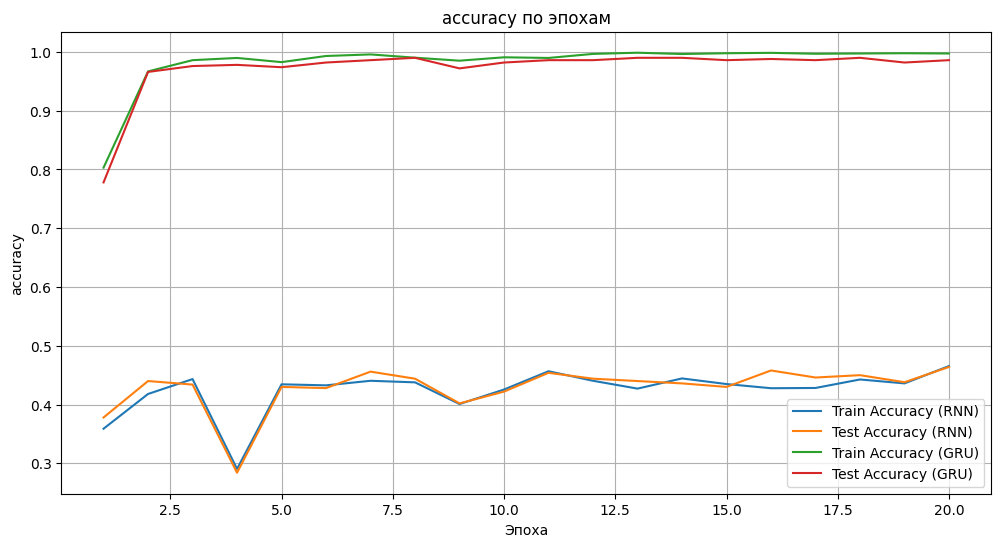

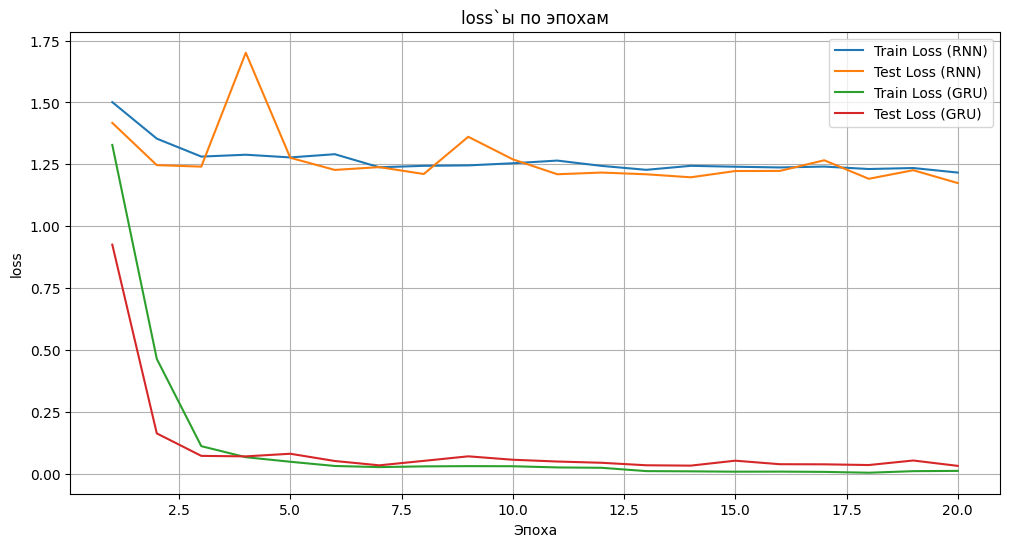

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_acc_rnn, label='Train Accuracy (RNN)')
plt.plot(range(1, num_epochs + 1), test_acc_rnn, label='Test Accuracy (RNN)')
plt.plot(range(1, num_epochs + 1), train_acc_gru, label='Train Accuracy (GRU)')
plt.plot(range(1, num_epochs + 1), test_acc_gru, label='Test Accuracy (GRU)')
plt.xlabel('Эпоха')
plt.ylabel('accuracy')
plt.title('accuracy по эпохам')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_loss_rnn, label='Train Loss (RNN)')
plt.plot(range(1, num_epochs + 1), test_loss_rnn, label='Test Loss (RNN)')
plt.plot(range(1, num_epochs + 1), train_loss_gru, label='Train Loss (GRU)')
plt.plot(range(1, num_epochs + 1), test_loss_gru, label='Test Loss (GRU)')
plt.xlabel('Эпоха')
plt.ylabel('loss')
plt.title('loss`ы по эпохам')
plt.legend()
plt.grid(True)
plt.show()

#### Задание 2 (8 баллов + 4 бонусных). Генерация антител

Поиграем за B-лимфоцит и попробуем создать новые антитела.

Модель - почти полная копия модели с практики, но есть дополнительное условие: теперь кроме текущего токена и предыдущего скрытого состояния пусть наша ячейка принимает ещё метку биологического вида, к которому должно относиться антитело, вроде такого:

In [42]:
class ConditionalRNNCell(nn.Module):
    """
    (x_{t}, h_{t-1}, c) -> h_{t}
    """
    def __init__(self, input_dim: int, hidden_dim: int, cond_dim: int) -> None:
        super().__init__()
        self.linear = nn.Linear(input_dim + hidden_dim + cond_dim, hidden_dim)


    def forward(self, x: Tensor, c: Tensor, h: Tensor) -> Tensor:
        # x: B x input_dim: эмбеддинг последнего токен
        # c: B x class_dim: эмбеддинг биологического вида
        # h: B x hidden_dim: последнее скрытое состояние
        combined = torch.cat([x, c, h], dim=1)  # B x (input_dim + class_dim + hidden_dim)
        h_new = self.linear(combined)
        h_new = torch.tanh(h_new)
        return h_new

**2.1. (2 балла)** Реализуйте архитектуру модели для генерации антител символ за символом

**2.2. (2 балла)** Обучите модель в течение 10-50 эпох, постройте графики функции ошибки.

**2.3. (4 балла)** Сгенерируйте с помощью модели по 20 антител для каждого биологического вида в отдельных ячейках, выведите их в ноутбуке. Воспользуйтесь функцией `get_sequence_score` (ниже), чтобы посчитать сходство ваших антител с природными (вернее - очень грубую оценку). Посчитайте, сколько антител из сгенерированных вами имеют оценку 0.55 и выше для каждого биологического вида.

**2.4. (Бонус 4 балла)** Повторите пункты 2.2 и 2.3, но используйте другой тип рекуррентной ячейки (GRU или LSTM).


In [43]:
class AntibodyGenerator(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        species_size: int,
        embedding_dim: int = 64,
        hidden_dim: int = 64,
    ) -> None:
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.species_embedding = nn.Embedding(species_size, embedding_dim)
        self.rnn_cell = ConditionalRNNCell(embedding_dim, hidden_dim, embedding_dim)
        self.output_layer = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x: Tensor, species_ids: Tensor) -> Tensor:
        # x: B x T (входные последовательности)
        # species_ids: B (метки биологического вида)
        batch_size, seq_len = x.size()
        device = x.device

        # Получаем эмбеддинги видов
        c = self.species_embedding(species_ids)  # B x embedding_dim

        # Инициализируем скрытое состояние
        h = torch.zeros(batch_size, self.rnn_cell.linear.out_features, device=device)

        outputs = []
        for t in range(seq_len):
            x_t = x[:, t]  # B
            x_emb = self.embedding(x_t)  # B x embedding_dim
            h = self.rnn_cell(x_emb, c, h)  # B x hidden_dim
            logits = self.output_layer(h)  # B x vocab_size
            outputs.append(logits.unsqueeze(1))  # B x 1 x vocab_size

        outputs = torch.cat(outputs, dim=1)  # B x T x vocab_size
        return outputs

Epoch 1/33, Train Loss: 2.4721, Test Loss: 2.0504
Epoch 2/33, Train Loss: 1.7682, Test Loss: 1.5842
Epoch 3/33, Train Loss: 1.4639, Test Loss: 1.3977
Epoch 4/33, Train Loss: 1.3329, Test Loss: 1.3042
Epoch 5/33, Train Loss: 1.2602, Test Loss: 1.2509
Epoch 6/33, Train Loss: 1.2152, Test Loss: 1.2127
Epoch 7/33, Train Loss: 1.1823, Test Loss: 1.1877
Epoch 8/33, Train Loss: 1.1570, Test Loss: 1.1642
Epoch 9/33, Train Loss: 1.1360, Test Loss: 1.1447
Epoch 10/33, Train Loss: 1.1203, Test Loss: 1.1294
Epoch 11/33, Train Loss: 1.1053, Test Loss: 1.1156
Epoch 12/33, Train Loss: 1.0928, Test Loss: 1.1051
Epoch 13/33, Train Loss: 1.0801, Test Loss: 1.0957
Epoch 14/33, Train Loss: 1.0688, Test Loss: 1.0827
Epoch 15/33, Train Loss: 1.0656, Test Loss: 1.0730
Epoch 16/33, Train Loss: 1.0531, Test Loss: 1.0845
Epoch 17/33, Train Loss: 1.0453, Test Loss: 1.0638
Epoch 18/33, Train Loss: 1.0376, Test Loss: 1.0557
Epoch 19/33, Train Loss: 1.0340, Test Loss: 1.0494
Epoch 20/33, Train Loss: 1.0278, Test Lo

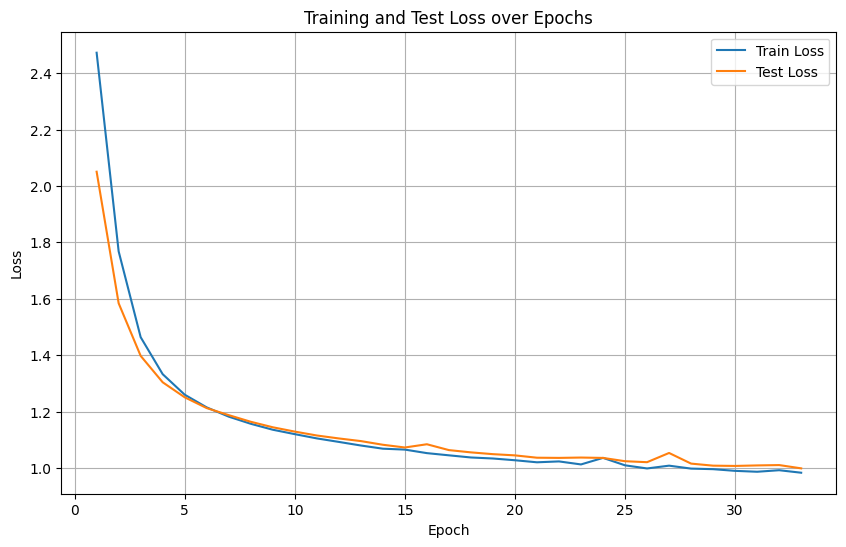

In [61]:
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vocab_size = len(VOCAB)
species_size = len(SPECIES)
model = AntibodyGenerator(
    vocab_size=vocab_size,
    species_size=species_size,
    embedding_dim=64,
    hidden_dim=64
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)  # Игнорируем паддинги
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 33
train_losses = []
test_losses = []

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    for x_batch, _ in train_loader:
        # Разделяем последовательности и метки видов
        sequences = x_batch[:, :-1].to(device)  # Входные символы
        targets = x_batch[:, 1:].to(device)     # Целевые символы (следующие символы)
        species_ids = _  # Предположим, что метки видов передаются вторым элементом
        species_ids = species_ids.to(device)

        optimizer.zero_grad()
        outputs = model(sequences, species_ids)  # outputs: B x T x vocab_size

        # Преобразуем для функции потерь
        outputs = outputs.reshape(-1, vocab_size)
        targets = targets.reshape(-1)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Оценка на тестовой выборке
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x_batch, _ in test_loader:
            sequences = x_batch[:, :-1].to(device)
            targets = x_batch[:, 1:].to(device)
            species_ids = _
            species_ids = species_ids.to(device)

            outputs = model(sequences, species_ids)
            outputs = outputs.reshape(-1, vocab_size)
            targets = targets.reshape(-1)

            loss = criterion(outputs, targets)
            total_loss += loss.item()

    avg_loss_test = total_loss / len(test_loader)
    test_losses.append(avg_loss_test)

    print(f"Epoch {epoch}/{num_epochs}, Train Loss: {avg_loss:.4f}, Test Loss: {avg_loss_test:.4f}")

# Построение графика функции потерь
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
! #pip install biopython==1.84

In [45]:
from Bio.Align import PairwiseAligner


def get_sequence_score(query_sequence: str) -> float:
    references = [
        "QVQLQQPGAELVKPGASVKMSCKAS_WITWVKQRPGQGLEWIGDI_TNYNEKFKTKATLTVDTSSSTAYMQLSSLTSEDSAVYYCAR_WGQGTSVTVSS",
        "EVKLEESGGGLVQPGGSMKLSCAAS_WMDWVRQSPEKGLEWVAEI_TYYAESVKGRFTISRDDSKSSVYLQMNSLRAEDTGIYYCTA_WGQGTLVTVSA",
        "HVQLVESGGGSVQPGGSLRLSCTVS_CMGWFRRAPGKEREKVATL_TSYADSVKGRFAISQDPAKNTLWLQMNSLKPEDSATYYCAA_SSRGTQVTVS",
        "QVQLVESGGGSVQAGGSLKLSCAAS_CMGWSRQAPGKGREGVARI_TAYADSVKGRFTISHDSIKNTLYLQMNSLRPEDTAKYYCAA_WGQGTQVTV",
        "QSLEESGGDLVKPGASLTLTCTAS_YMCWVRQAPGKGLEWIACI_TYYASWAKGRFTISKTSSTTVTLQMTSLTAADTATYFCAS_WGQGTLVTVS",
        "QEQLVESGGGLVKPGASLTLTCKAS_VMCWVRQAPGKGLEWIACI_SVYASWAKGRSTISRTSSTTVTLQMTSLTAADTATYFCAR_RGPGTLVTVS",
        "SVKVSCKAS_WIQWVRQAPGQGLEWMGWM_TTYSPKFQGRVSMTSDKSITTAYLELRGLTSDDTAVYSCAR_WGQGTLITVTS",
    ]
    max_score = 0.0
    for ref in map(lambda s: s.replace("_", ""), references):
        alignment = PairwiseAligner().align(query_sequence, ref)[0]
        n_matches = sum(
            1 for i in range(alignment.length) if alignment[0][i] == alignment[1][i]
        )
        max_score = max(max_score, n_matches / len(ref))

    return max_score

In [46]:
get_sequence_score("HESGGGAVTVSKETLSLTLTYEDTAIYYCAKDDVGGSSYSPVCWLSWGQGTQVTVS")

0.3763440860215054

In [47]:
get_sequence_score(
    "EVQLVESGGGLVQPGGSLRLSCAASGFTFSDDGMSWVRQAPGKGLEWVAVISSDGSQKSNADSVRDRFTISKDNSKNMLYLQMNNLRLEDTAVYFCTTFSYWGQGVQVTVSS"
)

0.7340425531914894

In [60]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F

inverse_vocab = {idx: token for token, idx in VOCAB.items()}

def decode_tokens(token_tensor: Tensor) -> list[str]:
    """
    Преобразует тензоры токенов в списки строк.
    """
    decoded = []
    for sequence in token_tensor:
        chars = [inverse_vocab.get(token.item(), '') for token in sequence]
        decoded.append(''.join(chars))
    return decoded

@torch.no_grad()
def generate_antibodies(model: nn.Module, initial_tokens: Tensor, species_label: int, max_length: int = 170) -> Tensor:
    """
    Генерирует последовательности антител для заданного вида.
    """
    batch_size = initial_tokens.size(0)
    species_tensor = torch.full((batch_size,), species_label, dtype=torch.long, device=device)
    generated = initial_tokens.to(device)
    
    for _ in range(max_length):
        logits = model(generated, species_tensor)[:, -1, :]  # Получаем последние логиты
        probabilities = F.softmax(logits, dim=1)
        next_tokens = torch.multinomial(probabilities, num_samples=1)
        generated = torch.cat((generated, next_tokens), dim=1)
    
    return generated

def evaluate_generated_sequences(model: nn.Module, start_token_idx: int, species_dict: dict, num_samples: int = 20, threshold: float = 0.55) -> dict:
    """
    Генерирует антитела для каждого вида и оценивает их качество.
    """
    performance = {}
    
    for species_name, species_id in species_dict.items():
        initial = torch.full((num_samples, 1), start_token_idx, dtype=torch.long, device=device)
        generated_tokens = generate_antibodies(model, initial, species_id, max_length=170)
        sequences = decode_tokens(generated_tokens.cpu())
        good_count = sum(get_sequence_score(seq) >= threshold for seq in sequences)
        performance[species_name] = good_count / num_samples
        
        print(f"Вид: {species_name}, Хороших антител: {good_count}/{num_samples}")
    
    return performance

start_token_index = VOCAB['_']
total_good_counts = evaluate_generated_sequences(
    model=model,
    start_token_idx=start_token_index,
    species_dict=SPECIES,
    num_samples=20,
    threshold=0.55
)

Вид: Camel, Хороших антител: 12/20
Вид: Human, Хороших антител: 13/20
Вид: Mouse, Хороших антител: 11/20
Вид: Rabbit, Хороших антител: 16/20
Вид: Rhesus, Хороших антител: 16/20
